In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask
import dask.array as da
import zarr
import pylops_distributed
from zarr.util import human_readable_size
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics.profile_visualize import visualize

client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn096:8786')
client

In [2]:
def write_concurrent(i, dzarr):
    print('Writing %d\n' % i)
    x = i * np.ones(dzarr.chunks)
    dzarr[i*dzarr.chunks[0]:(i+1)*dzarr.chunks[0]] = x
    print('Done writing %d\n' % i)
    return i

nchunks = 5
shape =(100, 100, 500)
dstore = zarr.DirectoryStore('test.zarr')
dzarr = zarr.create(store=dstore, shape=shape, 
                    chunks=(shape[0]//nchunks, shape[1], shape[2]), 
                    overwrite=True)

In [3]:
dzarr.info

Type,zarr.core.Array
Data type,float64
Shape,"(100, 100, 500)"
Chunk shape,"(20, 100, 500)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,40000000 (38.1M)
No. bytes stored,366
Storage ratio,109289.6


In [4]:
output = []
for i in range(nchunks):
    out = dask.delayed(write_concurrent)(i, dzarr)
    output.append(out)
total = dask.delayed(sum)(output)

total.compute()

Writing 4
Writing 1


Writing 0

Writing 2
Writing 3


Done writing 2

Done writing 4

Done writing 1

Done writing 0

Done writing 3



10

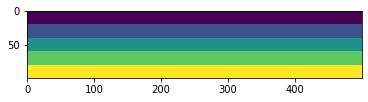

In [5]:
plt.imshow(dzarr[:, shape[1]//2])

In [6]:
ddask = da.from_zarr('test.zarr', chunks=(shape[0], shape[1], shape[2]//nchunks))
ddask

dask.array<from-zarr, shape=(100, 100, 500), dtype=float64, chunksize=(100, 100, 100)>

In [7]:
ddask = ddask.transpose((2, 0, 1))
ddask

dask.array<transpose, shape=(500, 100, 100), dtype=float64, chunksize=(100, 100, 100)>

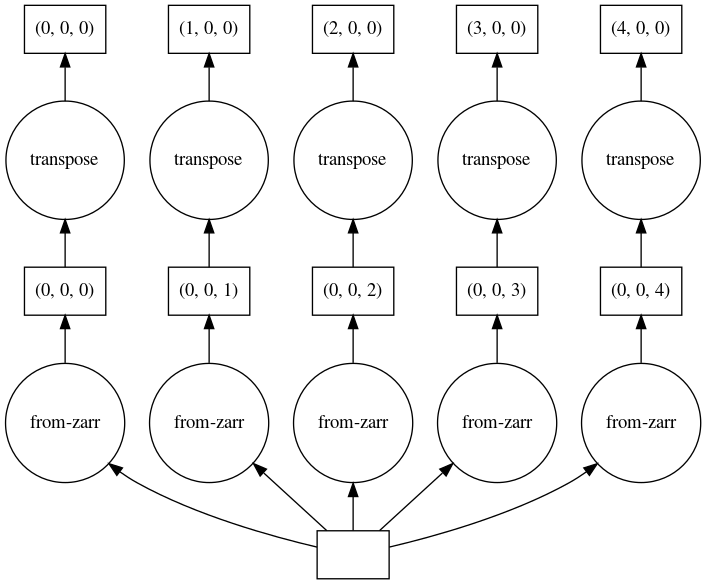

In [8]:
ddask.visualize()

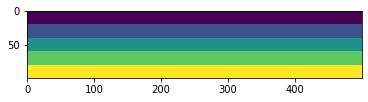

In [9]:
plt.imshow(dzarr[:, shape[1]//2])